In [ ]:
import json
import re
from collections import Counter
from kiwipiepy import Kiwi
import pandas as pd

jsonl_path = r"..\data\fmkorea_hot_posts.jsonl"
knu_path = r"..\data\KnuSentiLex\KnuSentiLex\data\SentiWord_info.json"

TARGET_DATE = "2025-11-04"   # <- 1월 15일(문자열이 파일에 저장된 형식과 같아야 함)

def normalize_repeats(s: str) -> str:
    s = re.sub(r"ㅋ{5,}", "ㅋㅋㅋㅋ", s)
    s = re.sub(r"ㅎ{5,}", "ㅎㅎㅎㅎ", s)
    s = re.sub(r"ㅠ{3,}", "ㅠㅠ", s)
    s = re.sub(r"ㅜ{3,}", "ㅜㅜ", s)
    return s

# Kiwi
kiwi = Kiwi()
kiwi.add_user_word("삼전", "NNP", 0)
kiwi.add_user_word("삼성전자", "NNP", 0)
kiwi.add_user_word("하닉", "NNP", 0)

STOP_TAGS = {
    "JKS","JKC","JKG","JKO","JKB","JKV","JKQ","JX","JC",
    "EP","EF","EC","ETN","ETM",
    "SF","SP","SS","SE","SO","SW"
}

# KNU 로드
with open(knu_path, "r", encoding="utf-8-sig") as f:
    knu = json.load(f)

lex_score = {}
for row in knu:
    w = str(row.get("word", "")).strip()
    if not w:
        continue
    try:
        lex_score[w] = float(row.get("polarity", 0))
    except (TypeError, ValueError):
        lex_score[w] = 0.0

custom_score = {
    "ㅋㅋ": 0.2, "ㅋㅋㅋ": 0.4, "ㅋㅋㅋㅋ": 0.6,
    "ㅎㅎ": 0.2, "ㅎㅎㅎ": 0.4, "ㅎㅎㅎㅎ": 0.6,
    "떡상": 2.5, "폭등": 2.5,
    "떡락": -2.5, "폭락": -2.5,
    "손절": -1.5, "망했다": -3.0, "조졌다": -3.0,
    "고점": -2.0,
}
final_lex = {**lex_score, **custom_score}

# === 여기부터 '하루만' 집계 ===
token_counter = Counter()
post_count = 0
comment_count = 0

with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue

        post = json.loads(line)

        # 1) 날짜 필터
        if post.get("date") != TARGET_DATE:
            continue

        post_count += 1
        comments = post.get("comments", [])
        comment_count += len(comments)

        # 2) 댓글 토큰화 → Counter 누적
        for c in comments:
            text = normalize_repeats(c.get("comment", ""))
            tokens = [t.form for t in kiwi.tokenize(text) if t.tag not in STOP_TAGS]
            token_counter.update(tokens)

# 3) 하루치 감성 점수 계산(유니크 토큰만 매칭)
matched_vocab = {w: final_lex[w] for w in token_counter if w in final_lex and float(final_lex[w]) != 0}
day_sent_score = sum(token_counter[w] * float(matched_vocab[w]) for w in matched_vocab)
label = "긍정" if day_sent_score > 0 else "부정" if day_sent_score < 0 else "중립"

print("날짜:", TARGET_DATE)
print("게시글 수:", post_count)
print("댓글 수:", comment_count)
print("유니크 토큰 수:", len(token_counter))
print("상위 토큰 20개:", token_counter.most_common(20))
print("사전 매칭 유니크 단어 수:", len(matched_vocab))
print("감성 점수(빈도 가중):", day_sent_score)
print("판정:", label)


In [ ]:
import os
import pandas as pd

out_path = r"..\data\token_counter_2026-01-15_all.csv"

# 1) 전부 저장 (유니크 토큰 전체)
token_df = pd.DataFrame(token_counter.most_common(), columns=["token", "count"])  # [web:366]
token_df.to_csv(out_path, index=False, encoding="utf-8-sig")  # [web:365]

# 2) 저장 확인(파일 존재/크기/행 수/미리보기)
print("saved:", out_path)
print("exists:", os.path.exists(out_path))
print("size(bytes):", os.path.getsize(out_path) if os.path.exists(out_path) else None)
print("rows(unique tokens):", len(token_df))


In [ ]:
print("a")

In [5]:
import json
import re
import math
from collections import Counter
from kiwipiepy import Kiwi
import pandas as pd

from transformers import pipeline


jsonl_path = r"..\data\fmkorea_hot_posts.jsonl"
knu_path = r"..\data\KnuSentiLex\KnuSentiLex\data\SentiWord_info.json"

TARGET_DATE = "2025-11-04"


def normalize_repeats(s: str) -> str:
    s = re.sub(r"ㅋ{5,}", "ㅋㅋㅋㅋ", s)
    s = re.sub(r"ㅎ{5,}", "ㅎㅎㅎㅎ", s)
    s = re.sub(r"ㅠ{3,}", "ㅠㅠ", s)
    s = re.sub(r"ㅜ{3,}", "ㅜㅜ", s)
    return s


# Kiwi
kiwi = Kiwi()
kiwi.add_user_word("삼전", "NNP", 0)
kiwi.add_user_word("삼성전자", "NNP", 0)
kiwi.add_user_word("하닉", "NNP", 0)

STOP_TAGS = {
    "JKS","JKC","JKG","JKO","JKB","JKV","JKQ","JX","JC",
    "EP","EF","EC","ETN","ETM",
    "SF","SP","SS","SE","SO","SW"
}


# KNU 로드
with open(knu_path, "r", encoding="utf-8-sig") as f:
    knu = json.load(f)

lex_score = {}
for row in knu:
    w = str(row.get("word", "")).strip()
    if not w:
        continue
    try:
        lex_score[w] = float(row.get("polarity", 0))
    except (TypeError, ValueError):
        lex_score[w] = 0.0

custom_score = {
    "ㅋㅋ": 0.2, "ㅋㅋㅋ": 0.4, "ㅋㅋㅋㅋ": 0.6,
    "ㅎㅎ": 0.2, "ㅎㅎㅎ": 0.4, "ㅎㅎㅎㅎ": 0.6,
    "떡상": 2.5, "폭등": 2.5,
    "떡락": -2.5, "폭락": -2.5,
    "손절": -1.5, "망했다": -3.0, "조졌다": -3.0,
    "고점": -2.0,
}
final_lex = {**lex_score, **custom_score}


# ====== (추가) HF 3분류 모델 로드 ======
MODEL_NAME = "jbeno/electra-base-classifier-sentiment"
clf = pipeline("text-classification", model=MODEL_NAME, top_k=None, truncation=True)  # 3라벨 확률 [web:129][web:119]


def scores_to_dict(out):
    # out: [{'label':'negative','score':...}, ...]
    d = {x["label"].lower(): float(x["score"]) for x in out}
    # 모델마다 라벨 대소문자/형태 차이가 있을 수 있어 방어적으로 처리
    return {
        "negative": d.get("negative", 0.0),
        "neutral": d.get("neutral", 0.0),
        "positive": d.get("positive", 0.0),
    }


def label_from_probs(p):
    # p: {'negative':..., 'neutral':..., 'positive':...}
    best = max(p, key=p.get)
    return {"negative": "부정", "neutral": "중립", "positive": "긍정"}[best]


def like_weight(like):
    # 0~큰 값까지 안정적으로: 1 + log(1+like)
    like = 0 if like is None else int(like)
    return 1.0 + math.log1p(max(like, 0))


# === 하루치 집계 ===
token_counter = Counter()
post_count = 0
comment_count = 0

# (추가) AI 집계용
ai_weight_sum = 0.0
ai_sum = {"negative": 0.0, "neutral": 0.0, "positive": 0.0}

with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue

        post = json.loads(line)

        if post.get("date") != TARGET_DATE:
            continue

        post_count += 1
        comments = post.get("comments", [])
        comment_count += len(comments)

        # 1) 댓글 토큰화 → Counter 누적 (기존)
        for c in comments:
            text = normalize_repeats(c.get("comment", ""))

            tokens = [t.form for t in kiwi.tokenize(text) if t.tag not in STOP_TAGS]
            token_counter.update(tokens)

        # 2) (추가) 댓글을 AI로 감성분석 후 like 가중 합산
        comment_texts = [normalize_repeats(c.get("comment", "")) for c in comments if c.get("comment")]
        if comment_texts:
            # batch 추론: 리스트로 넣으면 배치 처리됨 [web:99]
            outs = clf(comment_texts, top_k=None)  # 버전에 따라 중첩 리스트/단일 리스트 형태가 달라질 수 있음 [web:106][web:129]

            # outs 정규화: comment_texts 길이만큼 '각 댓글의 out(list[dict])'로 맞추기
            if outs and isinstance(outs[0], dict):
                # 텍스트 1개만 들어갔을 때 dict 리스트로 오는 케이스 방어
                outs = [outs]

            for c, out in zip(comments, outs):
                p = scores_to_dict(out)
                w = like_weight(c.get("like", 0))
                ai_sum["negative"] += w * p["negative"]
                ai_sum["neutral"] += w * p["neutral"]
                ai_sum["positive"] += w * p["positive"]
                ai_weight_sum += w


# 3) (기존) 하루치 사전 감성 점수
matched_vocab = {w: final_lex[w] for w in token_counter if w in final_lex and float(final_lex[w]) != 0}
day_sent_score = sum(token_counter[w] * float(matched_vocab[w]) for w in matched_vocab)
lex_label = "긍정" if day_sent_score > 0 else "부정" if day_sent_score < 0 else "중립"

# 4) (추가) 하루치 AI 확률/라벨
if ai_weight_sum > 0:
    ai_probs = {k: v / ai_weight_sum for k, v in ai_sum.items()}
    ai_label = label_from_probs(ai_probs)
else:
    ai_probs = {"negative": 0.0, "neutral": 0.0, "positive": 0.0}
    ai_label = "중립"

# 5) (옵션) 하이브리드: AI가 애매할 때만 사전으로 보정(원하면 임계값 조정)
ai_conf = max(ai_probs.values())
if ai_conf < 0.50:
    final_label = lex_label
else:
    final_label = ai_label


print("날짜:", TARGET_DATE)
print("게시글 수:", post_count)
print("댓글 수:", comment_count)
print("유니크 토큰 수:", len(token_counter))
print("상위 토큰 20개:", token_counter.most_common(20))
print("사전 매칭 유니크 단어 수:", len(matched_vocab))
print("사전 감성 점수(빈도 가중):", day_sent_score)
print("사전 판정:", lex_label)

print("\n[AI 모델]", MODEL_NAME)
print("AI 확률(가중평균):", ai_probs)
print("AI 판정:", ai_label)
print("최종(하이브리드) 판정:", final_label)


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at jbeno/electra-base-classifier-sentiment and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


날짜: 2025-11-04
게시글 수: 11
댓글 수: 228
유니크 토큰 수: 774
상위 토큰 20개: [('하', 128), ('이', 54), ('🥳', 36), ('보', 29), ('거', 23), ('있', 21), ('감사', 20), ('나', 15), ('주', 15), ('안', 13), ('것', 13), ('아니', 13), ('되', 12), ('말', 11), ('HBM', 10), ('때', 9), ('다', 9), ('가', 9), ('4', 9), ('고수', 8)]
사전 매칭 유니크 단어 수: 27
사전 감성 점수(빈도 가중): 59.0
사전 판정: 긍정

[AI 모델] jbeno/electra-base-classifier-sentiment
AI 확률(가중평균): {'negative': 0.29296118653009956, 'neutral': 0.35737514183413643, 'positive': 0.3496636754285904}
AI 판정: 중립
최종(하이브리드) 판정: 긍정


In [ ]:
# %pip install -U "transformers[torch]" huggingface_hub

In [3]:
import json
import re
from collections import Counter, defaultdict
from kiwipiepy import Kiwi
import pandas as pd

jsonl_path = r"..\data\fmkorea_samsung_hot_posts.jsonl"

START_DATE = pd.to_datetime("2026-01-01").date()
END_DATE   = pd.to_datetime("2026-01-16").date()

OUT_CSV = r"..\완료\daily_outputs\fmkorea_tokens_daily_2025-01-14_2026-01-14.csv"


def normalize_repeats(s: str) -> str:
    s = re.sub(r"ㅋ{5,}", "ㅋㅋㅋㅋ", s)
    s = re.sub(r"ㅎ{5,}", "ㅎㅎㅎㅎ", s)
    s = re.sub(r"ㅠ{3,}", "ㅠㅠ", s)
    s = re.sub(r"ㅜ{3,}", "ㅜㅜ", s)
    return s


# Kiwi
kiwi = Kiwi()
kiwi.add_user_word("삼전", "NNP", 0)
kiwi.add_user_word("삼성전자", "NNP", 0)
kiwi.add_user_word("하닉", "NNP", 0)
kiwi.add_user_word("하이닉스", "NNP", 0)

STOP_TAGS = {
    "JKS","JKC","JKG","JKO","JKB","JKV","JKQ","JX","JC",
    "EP","EF","EC","ETN","ETM",
    "SF","SP","SS","SE","SO","SW"
}

def tokenize_text(text: str) -> list[str]:
    """본문/댓글 공통 토큰화: 반복 문자 정규화 + 품사 필터"""
    text = normalize_repeats(text or "")
    return [t.form for t in kiwi.tokenize(text) if t.tag not in STOP_TAGS]  # kiwi.tokenize 사용 [web:73]


# =========================
# 날짜별 누적 저장소
# =========================
daily_post_count = defaultdict(int)
daily_comment_count = defaultdict(int)
daily_token_counter = defaultdict(Counter)

# (선택) 너무 커지면 끄기: 날짜별 상위 토큰만 뽑아 저장할 때 유용
# daily_total_token = defaultdict(int)

with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue

        post = json.loads(line)

        # 1) 날짜 파싱/필터
        date_str = post.get("date")
        if not date_str:
            continue

        d = pd.to_datetime(date_str, errors="coerce")
        if pd.isna(d):
            continue

        d = d.date()
        if d < START_DATE or d > END_DATE:
            continue

        # 2) 본문 + 댓글 토큰화
        daily_post_count[d] += 1

        # ✅ 본문 키 이름은 데이터에 맞게 조정 가능: content/body/text 중 하나일 수 있음
        body = post.get("content") or post.get("body") or post.get("text") or ""
        daily_token_counter[d].update(tokenize_text(body))

        comments = post.get("comments", [])
        daily_comment_count[d] += len(comments)

        for c in comments:
            # 네 원본 코드: c.get("comment")
            c_text = ""
            if isinstance(c, dict):
                c_text = c.get("comment", "") or c.get("content", "") or c.get("text", "")
            else:
                c_text = str(c)
            daily_token_counter[d].update(tokenize_text(c_text))

# =========================
# 일별 DataFrame 생성(빈 날짜 0 포함)
# =========================
rows = []
for d in pd.date_range(START_DATE, END_DATE, freq="D").date:
    counter = daily_token_counter.get(d, Counter())
    total_tokens = sum(counter.values())
    unique_tokens = len(counter)

    rows.append({
        "날짜": pd.to_datetime(d).strftime("%Y-%m-%d"),
        "게시글수": int(daily_post_count.get(d, 0)),
        "댓글수": int(daily_comment_count.get(d, 0)),
        "총토큰수": int(total_tokens),
        "유니크토큰수": int(unique_tokens),
        "상위토큰20": counter.most_common(20),  # most_common 사용 [web:386]
    })

daily_df = pd.DataFrame(rows)
daily_df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("[저장]", OUT_CSV)


[저장] ..\완료\daily_outputs\fmkorea_tokens_daily_2025-01-14_2026-01-14.csv


[CSV 저장] ..\완료\daily_outputs\fmkorea_tokens.csv


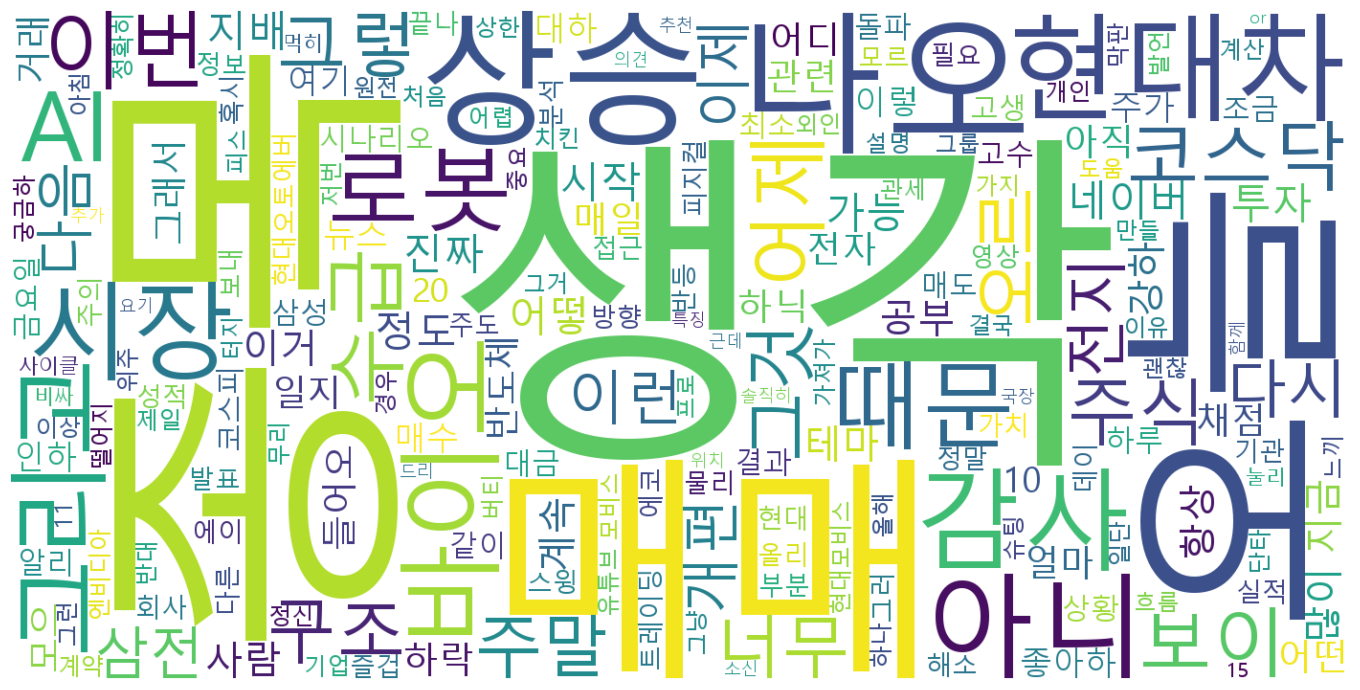

[워드클라우드 저장] ..\완료\daily_outputs\wc.png


In [6]:
import json
import re
from collections import Counter, defaultdict
from kiwipiepy import Kiwi
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt


jsonl_path = r"..\data\fmkorea_samsung_hot_posts.jsonl"

START_DATE = pd.to_datetime("2025-12-05").date()
END_DATE   = pd.to_datetime("2025-12-05").date()

OUT_CSV = r"..\완료\daily_outputs\fmkorea_tokens.csv"
OUT_WC_PNG = r"..\완료\daily_outputs\wc.png"
FONT_PATH = r"C:\Windows\Fonts\malgun.ttf"


def normalize_repeats(s: str) -> str:
    s = re.sub(r"ㅋ{5,}", "ㅋㅋㅋㅋ", s)
    s = re.sub(r"ㅎ{5,}", "ㅎㅎㅎㅎ", s)
    s = re.sub(r"ㅠ{3,}", "ㅠㅠ", s)
    s = re.sub(r"ㅜ{3,}", "ㅜㅜ", s)
    return s


# Kiwi
kiwi = Kiwi()
kiwi.add_user_word("삼전", "NNP", 0)
kiwi.add_user_word("삼성전자", "NNP", 0)
kiwi.add_user_word("하닉", "NNP", 0)
kiwi.add_user_word("하이닉스", "NNP", 0)

STOP_TAGS = {
    "JKS","JKC","JKG","JKO","JKB","JKV","JKQ","JX","JC",
    "EP","EF","EC","ETN","ETM",
    "SF","SP","SS","SE","SO","SW"
}

def tokenize_text(text: str) -> list[str]:
    """방법2: Kiwi 토큰 + 1글자 무시"""
    text = normalize_repeats(text or "")
    out = []
    for t in kiwi.tokenize(text):  # t.form / t.tag 사용 [web:73]
        if t.tag in STOP_TAGS:
            continue
        if len(t.form) < 2:        # ✅ 1글자 토큰 제거
            continue
        out.append(t.form)
    return out


# =========================
# 날짜별 누적 저장소
# =========================
daily_post_count = defaultdict(int)
daily_comment_count = defaultdict(int)
daily_token_counter = defaultdict(Counter)

# 기간 전체 토큰(워드클라우드 1장용)
period_counter = Counter()

with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue

        post = json.loads(line)

        date_str = post.get("date")
        if not date_str:
            continue

        d = pd.to_datetime(date_str, errors="coerce")
        if pd.isna(d):
            continue

        d = d.date()
        if d < START_DATE or d > END_DATE:
            continue

        daily_post_count[d] += 1

        body = post.get("content") or post.get("body") or post.get("text") or ""
        toks = tokenize_text(body)
        daily_token_counter[d].update(toks)
        period_counter.update(toks)

        comments = post.get("comments", [])
        daily_comment_count[d] += len(comments)

        for c in comments:
            if isinstance(c, dict):
                c_text = c.get("comment", "") or c.get("content", "") or c.get("text", "")
            else:
                c_text = str(c)
            toks = tokenize_text(c_text)
            daily_token_counter[d].update(toks)
            period_counter.update(toks)

# =========================
# 일별 DataFrame 생성
# =========================
rows = []
for d in pd.date_range(START_DATE, END_DATE, freq="D").date:
    counter = daily_token_counter.get(d, Counter())
    total_tokens = sum(counter.values())
    unique_tokens = len(counter)

    rows.append({
        "날짜": pd.to_datetime(d).strftime("%Y-%m-%d"),
        "게시글수": int(daily_post_count.get(d, 0)),
        "댓글수": int(daily_comment_count.get(d, 0)),
        "총토큰수": int(total_tokens),
        "유니크토큰수": int(unique_tokens),
        "상위토큰20": counter.most_common(20),
    })

daily_df = pd.DataFrame(rows)
daily_df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print("[CSV 저장]", OUT_CSV)

# =========================
# 기간 전체 워드클라우드 1장 생성
# =========================
wc = WordCloud(
    font_path=FONT_PATH,
    background_color="white",
    width=1400, height=700,
    max_words=200
).generate_from_frequencies(dict(period_counter))  # 빈도 기반 생성 [web:584][web:592]

plt.figure(figsize=(14, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig(OUT_WC_PNG, dpi=200)
plt.show()
print("[워드클라우드 저장]", OUT_WC_PNG)
